In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append(os.getcwd()+"/../../")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from ood_detection_helper import *

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
sns.set(style="darkgrid")

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  0
[]


'2.2.0'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Loading OOD datasets

In [4]:
with open("train_scores.p", "rb") as f:
    train_scores = pickle.load(f)
train_scores.shape

(50000, 10)

In [5]:
with open("scores_ckpt-9.p", "rb") as f:
    score_dict = pickle.load(f)
score_dict.keys()

dict_keys(['cifar', 'celeba', 'svhn'])

In [6]:
inlier_scores = score_dict["cifar"]
outlier_scores = [score_dict["celeba"], score_dict["svhn"]]

In [7]:
with open("ood_scores_ckpt-9.p", "rb") as f:
    ood_dict = pickle.load(f)
outlier_scores.extend([x for x in ood_dict.values()])

In [8]:
non_synthetic_images = ['LSUN','LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN']
outlier_scores.append(np.concatenate([ood_dict[n].numpy() for n in non_synthetic_images]))

In [9]:
ood_names = list(score_dict.keys())[1:] + list(ood_dict.keys()) + ["All Images"]
ood_names, len(outlier_scores)

(['celeba',
  'svhn',
  'LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform',
  'All Images'],
 10)

In [10]:
LABELS = np.array(["Train", "CIFAR", "CelebA", "SVHN", 'LSUN_crop','LSUN_resize',
                   'Imagenet_crop','Imagenet_resize','iSUN',"Gaussian", "Uniform", "All Images"])
COLORS = sns.color_palette("bright")

## Separation for lowest Sigma 

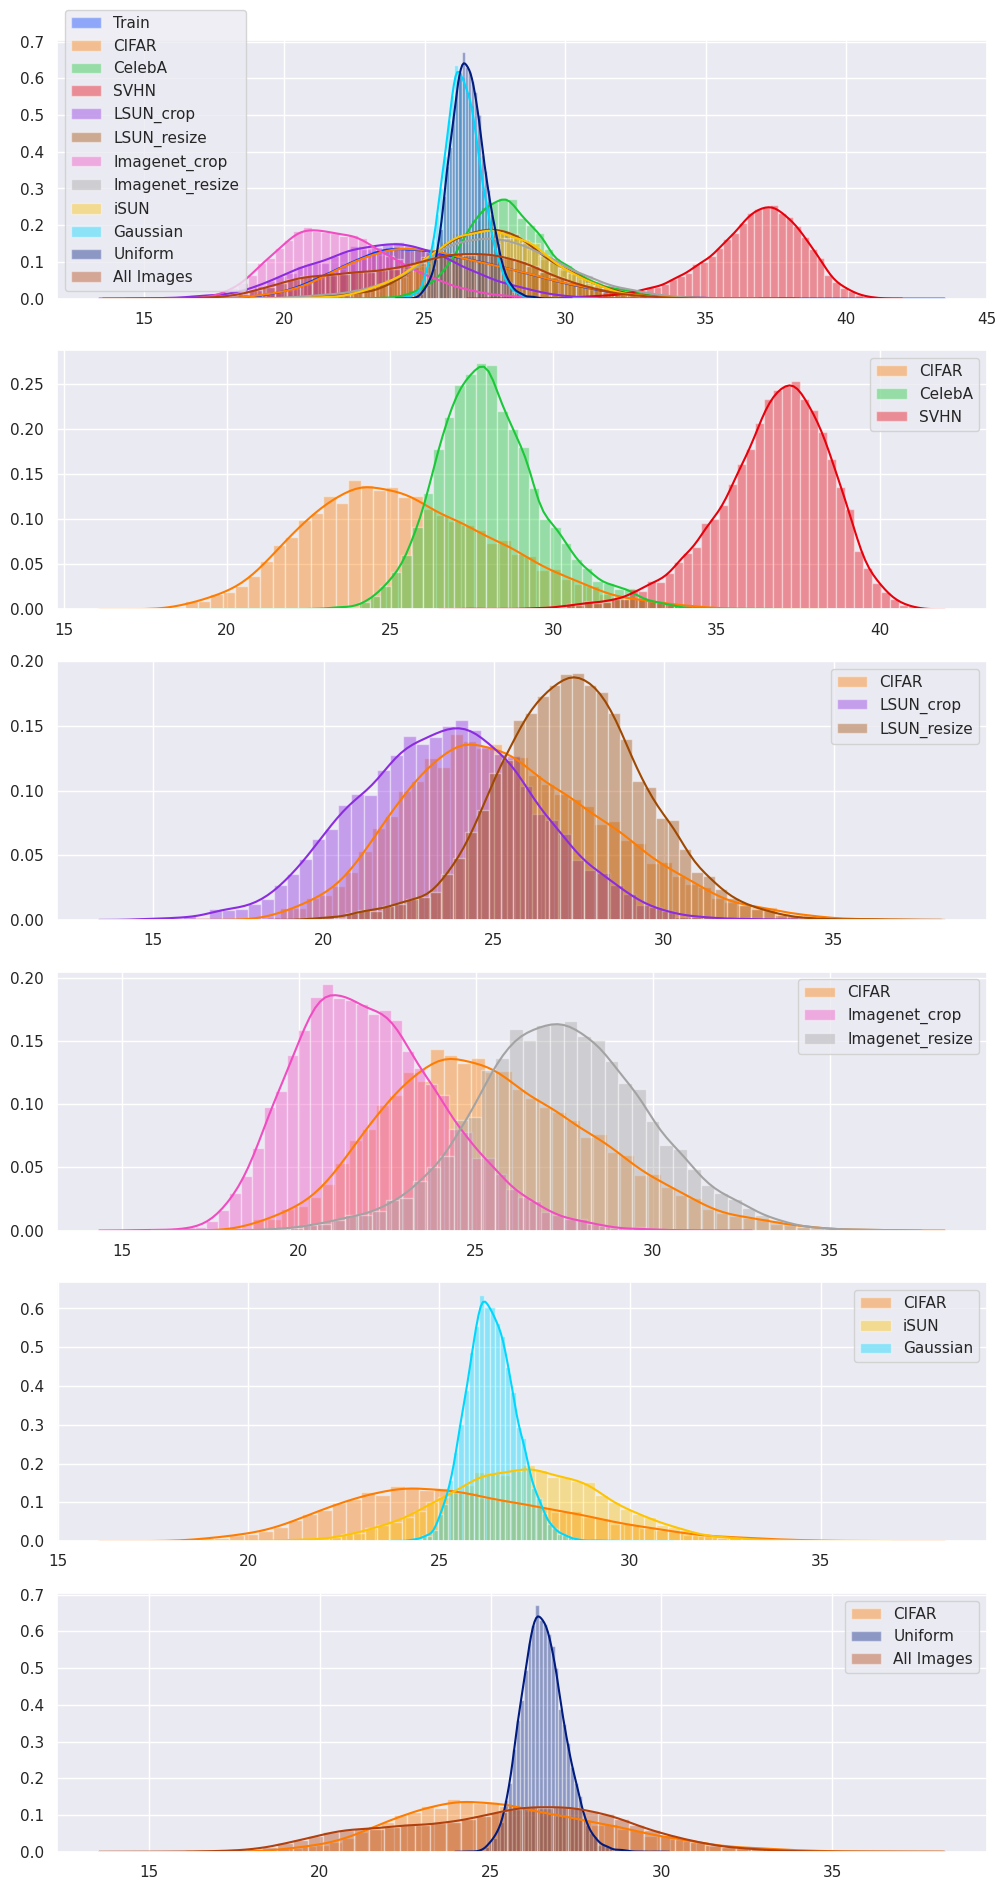

In [11]:
cifar_score = inlier_scores[:, -1]
ood_scores = [ood[:,-1] for ood in outlier_scores]

evaluate_model(train_scores[:,-1], cifar_score, ood_scores, labels=LABELS)

# Auxiliary model analysis

In [12]:
# Train Data = L2-norm(Pixel Scores)
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.6min finished


Best: 2.537667 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
2.104552 (0.049774) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.345474 (0.048771) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.430960 (0.048454) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.450245 (0.049639) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.486727 (0.039441) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.508356 (0.046020) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.517210 (0.046622) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.529093 (0.040523) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.534306 (0.045865) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.537667 (0.041959) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


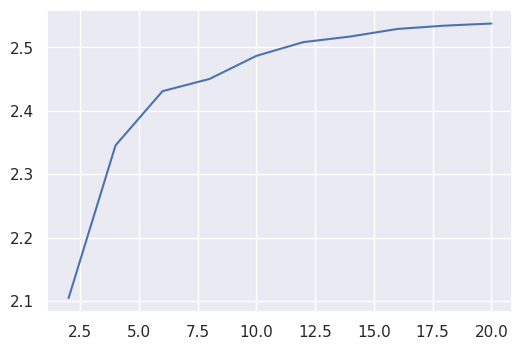

---Likelihoods---
Training: 2.571
CIFAR: 2.427
CelebA: 0.746
SVHN: -4.141
LSUN_crop: -1107.193
LSUN_resize: -598.962
Imagenet_crop: -637.780
Imagenet_resize: -785.234
iSUN: -648.239
Gaussian: -397.469
Uniform: -364.227
All Images: -757.838
========================= Training Flow Model =========================
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Epoch 1/1000
390/390 [==============================] - 1s 4ms/step - loss: 13294.1895 - val_loss: 5945.9878
Epoch 2/1000
390/390 [==============================] - 1s 3ms/step - loss: 3491.8000 - val_loss: 1980.7640
Epoch 3/1000
390/390 [==============================] - 1s 4ms/step - loss: 1368.7843 - val_loss: 979.8859
Epoch 4/1000
390/390 [==============================] - 1s 3ms/step - loss: 798.8324 - val_loss: 673.3582
Epoch 5/1000
390/390 [==============================] - 1s 3ms/step - loss: 602.6508 - val_loss: 551.5465
Epoch 6/1000
390/390 [===========

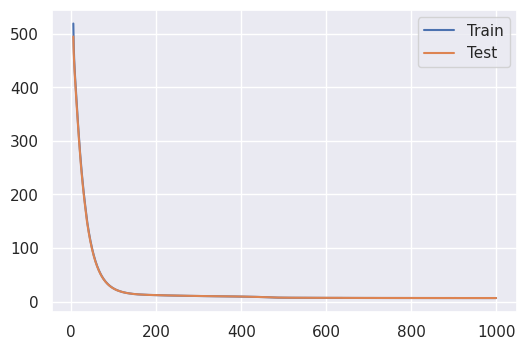

========================= Training KD Tree =========================
CPU times: user 58min 38s, sys: 24min 37s, total: 1h 23min 15s
Wall time: 22min 19s


In [13]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

## GMM

In [14]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,80.89,37.000000,67.707240,63.824096,68.327137,55.19,63.837289
SVHN,10.57,7.690000,95.889604,92.498747,97.109082,5.87,92.506818
LSUN_crop,0.00,0.020000,99.999854,99.999855,99.999854,0.00,99.999855
LSUN_resize,0.00,0.045000,99.999584,99.999590,99.999581,0.00,99.999590
Imagenet_crop,0.00,0.040000,99.999925,99.999925,99.999925,0.00,99.999925
Imagenet_resize,0.00,0.020000,99.999973,99.999973,99.999973,0.00,99.999973
iSUN,0.00,0.026204,99.999464,99.999424,99.999513,0.00,99.999424
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.033396,99.999767,99.999952,99.998846,0.00,99.999953


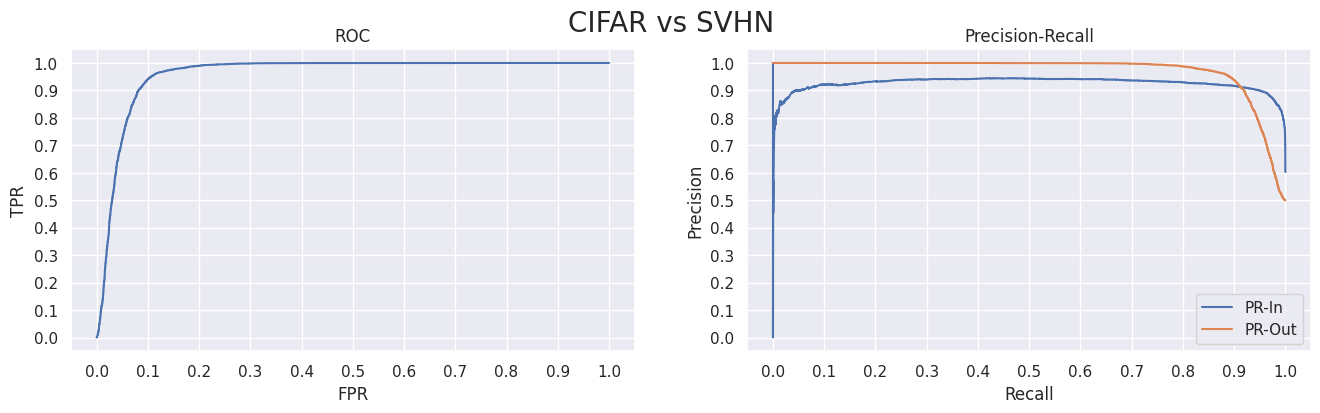

CIFAR vs SVHN
----------------
ROC-AUC: 95.8896
PR-AUC (In/Out): 92.4987 / 97.1091
FPR (95% TPR): 10.57%
Detection Error: 7.69%


{'fpr_tpr95': 0.1057,
 'de': 0.07690000000000002,
 'roc_auc': 0.95889604,
 'pr_auc_in': 0.9249874675503481,
 'pr_auc_out': 0.9710908224604085,
 'fpr_tpr80': 0.0587,
 'ap': 0.9250681846433947}

In [15]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

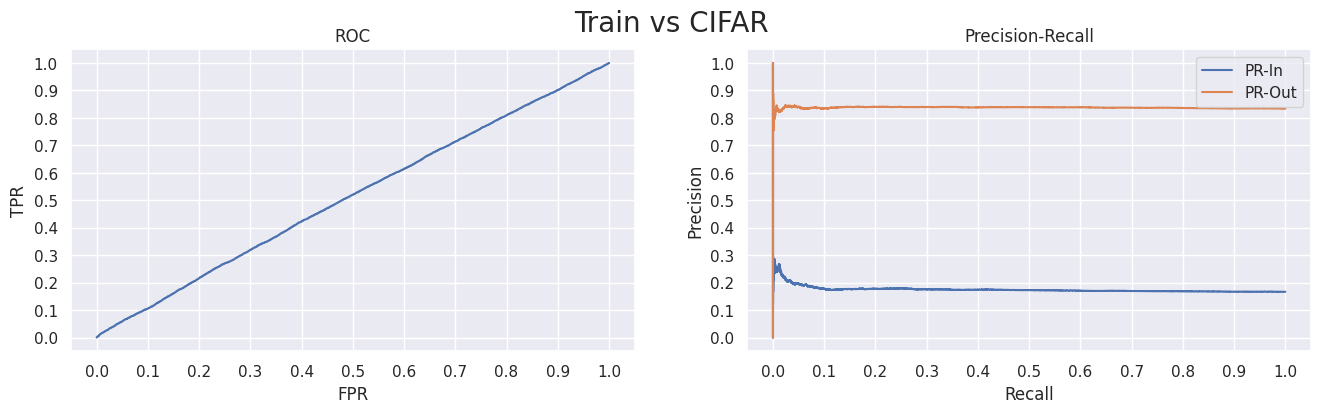

Train vs CIFAR
----------------
ROC-AUC: 51.2894
PR-AUC (In/Out): 17.4957 / 83.7403
FPR (95% TPR): 94.75%
Detection Error: 48.80%


{'fpr_tpr95': 0.94746,
 'de': 0.48797999999999997,
 'roc_auc': 0.512894474,
 'pr_auc_in': 0.17495683821073738,
 'pr_auc_out': 0.8374034887872269,
 'fpr_tpr80': 0.78028,
 'ap': 0.1750495543643971}

In [16]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [17]:
results["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,85.14,40.635000,62.648299,59.327782,63.251995,61.88,59.340698
SVHN,8.84,6.830000,96.427986,92.247248,97.584942,4.74,92.256366
LSUN_crop,0.00,0.035000,99.999705,99.999709,99.999703,0.00,99.999709
LSUN_resize,0.00,0.045000,99.999707,99.999709,99.999706,0.00,99.999709
Imagenet_crop,0.00,0.030000,99.999924,99.999924,99.999924,0.00,99.999924
Imagenet_resize,0.00,0.015000,99.999975,99.999975,99.999975,0.00,99.999975
iSUN,0.00,0.037409,99.999339,99.999295,99.999396,0.00,99.999295
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.033396,99.999739,99.999947,99.998706,0.00,99.999947


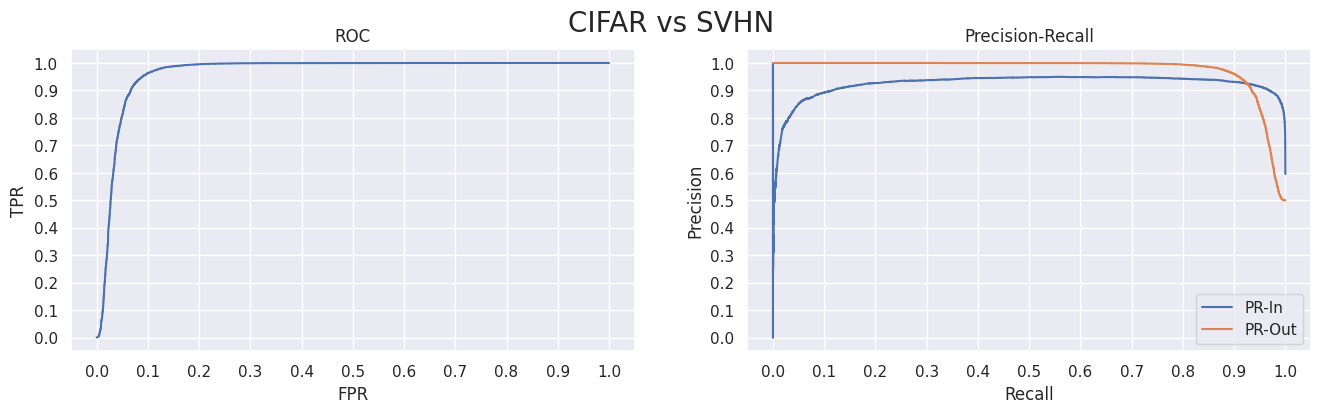

CIFAR vs SVHN
----------------
ROC-AUC: 96.4280
PR-AUC (In/Out): 92.2472 / 97.5849
FPR (95% TPR): 8.84%
Detection Error: 6.83%


{'fpr_tpr95': 0.0884,
 'de': 0.06829999999999997,
 'roc_auc': 0.964279855,
 'pr_auc_in': 0.9224724776358514,
 'pr_auc_out': 0.9758494242422804,
 'fpr_tpr80': 0.0474,
 'ap': 0.9225636614080751}

In [18]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

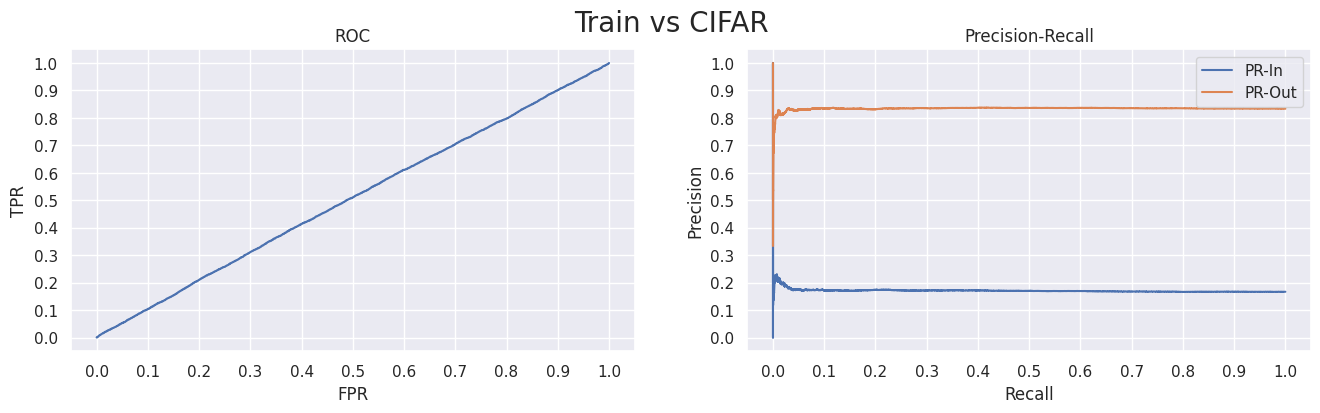

Train vs CIFAR
----------------
ROC-AUC: 50.6100
PR-AUC (In/Out): 17.0486 / 83.3963
FPR (95% TPR): 95.07%
Detection Error: 49.24%


{'fpr_tpr95': 0.9507,
 'de': 0.49239,
 'roc_auc': 0.5061001549999999,
 'pr_auc_in': 0.17048592904371532,
 'pr_auc_out': 0.8339634121549249,
 'fpr_tpr80': 0.79204,
 'ap': 0.17056261495682692}

In [19]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [20]:
results["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,78.55,39.265000,62.687221,56.979063,66.537606,57.65,56.991708
SVHN,4.11,4.480000,99.148397,99.069617,99.208808,0.65,99.069714
LSUN_crop,0.23,0.860000,99.946453,99.942667,99.950955,0.03,99.942670
LSUN_resize,0.57,1.450000,99.858522,99.838443,99.874196,0.11,99.838454
Imagenet_crop,0.51,1.405000,99.864705,99.843345,99.881427,0.11,99.843356
Imagenet_resize,0.25,0.990000,99.933930,99.926449,99.940817,0.03,99.926454
iSUN,0.39,1.249804,99.892598,99.862438,99.914401,0.06,99.862448
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.38,1.218327,99.899388,99.976755,99.656194,0.05,99.976755


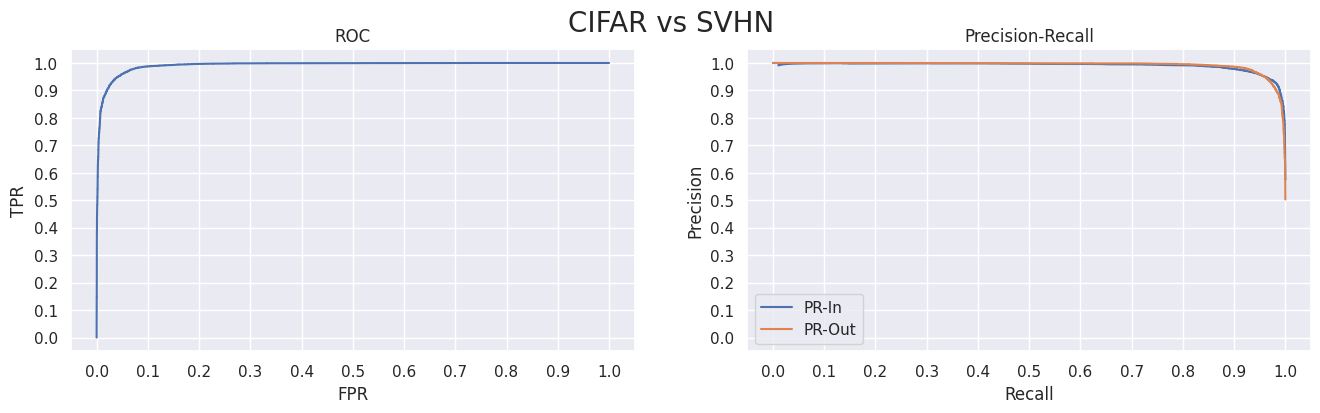

CIFAR vs SVHN
----------------
ROC-AUC: 99.1484
PR-AUC (In/Out): 99.0696 / 99.2088
FPR (95% TPR): 4.11%
Detection Error: 4.48%


{'fpr_tpr95': 0.0411,
 'de': 0.044800000000000006,
 'roc_auc': 0.9914839700000001,
 'pr_auc_in': 0.9906961651441349,
 'pr_auc_out': 0.9920880827440841,
 'fpr_tpr80': 0.0065,
 'ap': 0.9906971353462364}

In [21]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

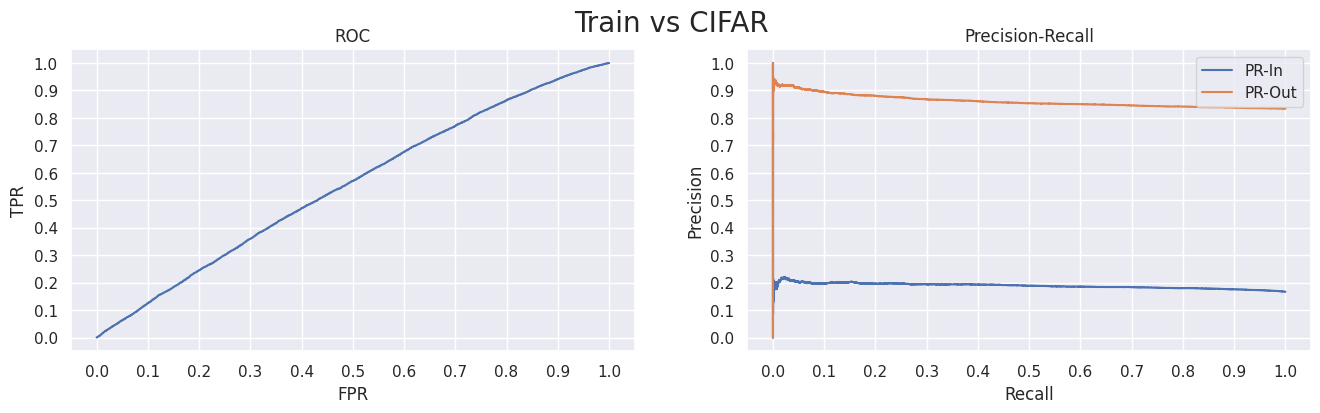

Train vs CIFAR
----------------
ROC-AUC: 55.2840
PR-AUC (In/Out): 18.8324 / 86.0710
FPR (95% TPR): 91.09%
Detection Error: 46.07%


{'fpr_tpr95': 0.91088,
 'de': 0.46065999999999996,
 'roc_auc': 0.552839922,
 'pr_auc_in': 0.18832372951924875,
 'pr_auc_out': 0.8607102295805986,
 'fpr_tpr80': 0.72198,
 'ap': 0.18840465215808516}

In [22]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## GMM vs Flow vs K-NN Tree on CIFAR vs All (including SVHN and synthetic)

CIFAR vs All
----------------
ROC-AUC: 99.4791
PR-AUC (In/Out): 99.9322 / 97.1087
FPR (95% TPR): 3.73%
Detection Error: 4.24%
CIFAR vs All
----------------
ROC-AUC: 99.5473
PR-AUC (In/Out): 99.9407 / 97.5845
FPR (95% TPR): 3.23%
Detection Error: 3.68%
CIFAR vs All
----------------
ROC-AUC: 99.8297
PR-AUC (In/Out): 99.9773 / 98.9755
FPR (95% TPR): 0.57%
Detection Error: 1.81%


Text(0.5, 0.98, 'Comparing Auxiliary Methods')

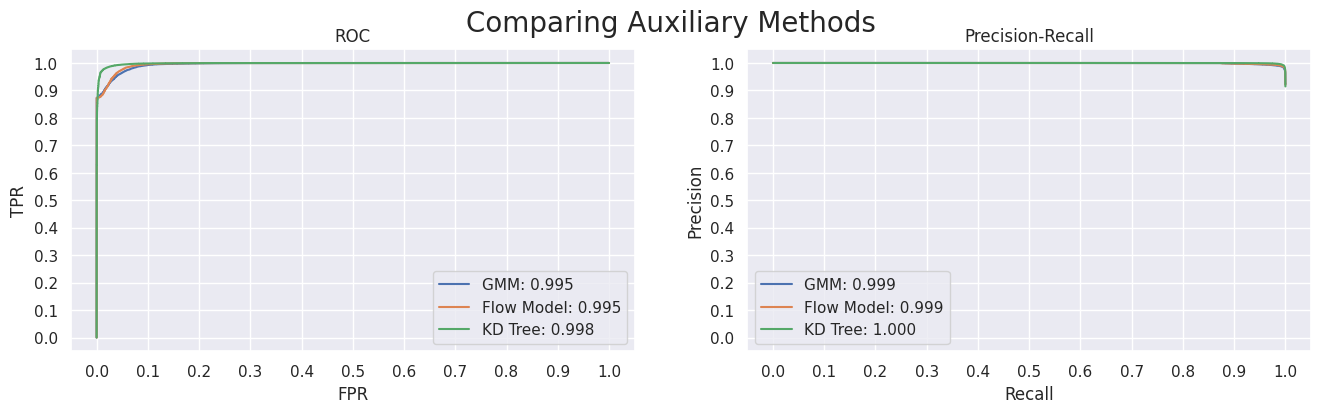

In [25]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][1:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][1:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][1:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "All"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)

# for ax in axs:
#     ax.set(ylim=(0.8, 1.01), yticks=np.arange(0.8, 1.01, step=0.05))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
# plt.savefig("../../Figures/aux.png", dpi=200)

## Bonus analysis with CIFAR 10.1 as train set

In [26]:
with open("cifar101_scores_ckpt-9.p", "rb") as f:
    cifar101_scores = pickle.load(f).numpy()
cifar101_scores.shape

(2000, 10)

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    6.1s finished


Best: 2.194307 using {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
---------------------------------------------------------------------------
2.024619 (0.181146) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.194307 (0.177341) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.182235 (0.170860) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.122538 (0.167505) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.081150 (0.182145) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
1.974501 (0.188805) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
1.857213 (0.204468) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
1.772378 (0.229621) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
1.686915 (0.282030) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
1.575411 (0.220421) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


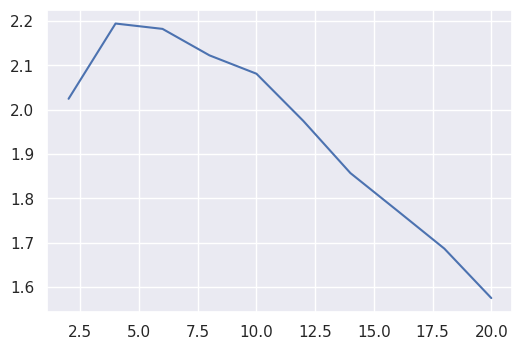

---Likelihoods---
Training: 2.389
CIFAR: 2.189
CelebA: 0.748
SVHN: -7.976
LSUN_crop: -1822.745
LSUN_resize: -970.452
Imagenet_crop: -1048.390
Imagenet_resize: -1277.995
iSUN: -1056.156
Gaussian: -1076.157
Uniform: -700.828
All Images: -1239.081
========================= Training Flow Model =========================
Epoch 1/500
15/15 [==============================] - 0s 22ms/step - loss: 45216.6055 - val_loss: 33581.2461
Epoch 2/500
15/15 [==============================] - 0s 12ms/step - loss: 26652.6426 - val_loss: 23067.1484
Epoch 3/500
15/15 [==============================] - 0s 13ms/step - loss: 19445.9004 - val_loss: 17890.9512
Epoch 4/500
15/15 [==============================] - 0s 12ms/step - loss: 15579.4795 - val_loss: 14721.0508
Epoch 5/500
15/15 [==============================] - 0s 13ms/step - loss: 13188.5723 - val_loss: 12493.9717
Epoch 6/500
15/15 [==============================] - 0s 15ms/step - loss: 11213.8535 - val_loss: 10849.7764
Epoch 7/500
15/15 [================

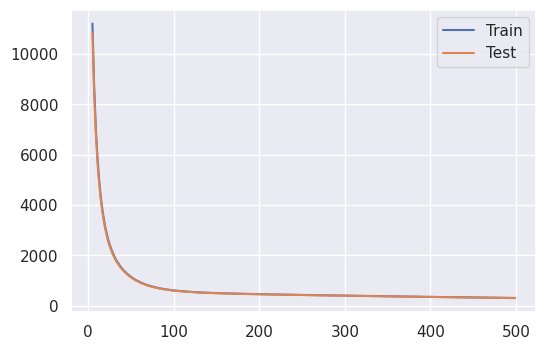

========================= Training KD Tree =========================
CPU times: user 3min 56s, sys: 1min 14s, total: 5min 11s
Wall time: 2min 1s


In [37]:
%%time
results_101 = auxiliary_model_analysis(cifar101_scores, X_test, outlier_scores, LABELS, flow_epochs=500)

## GMM

In [28]:
results_101["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,80.54,39.055000,64.999080,61.049409,67.367283,58.07,61.059125
SVHN,8.03,6.430000,97.519812,95.858385,98.139466,3.38,95.865192
LSUN_crop,0.00,0.035000,99.999747,99.999751,99.999745,0.00,99.999751
LSUN_resize,0.00,0.060000,99.999397,99.999406,99.999393,0.00,99.999406
Imagenet_crop,0.00,0.055000,99.999848,99.999848,99.999848,0.00,99.999848
Imagenet_resize,0.00,0.035000,99.999954,99.999954,99.999954,0.00,99.999954
iSUN,0.00,0.036807,99.999461,99.999419,99.999511,0.00,99.999419
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,0.00,0.045549,99.999686,99.999936,99.998452,0.00,99.999936


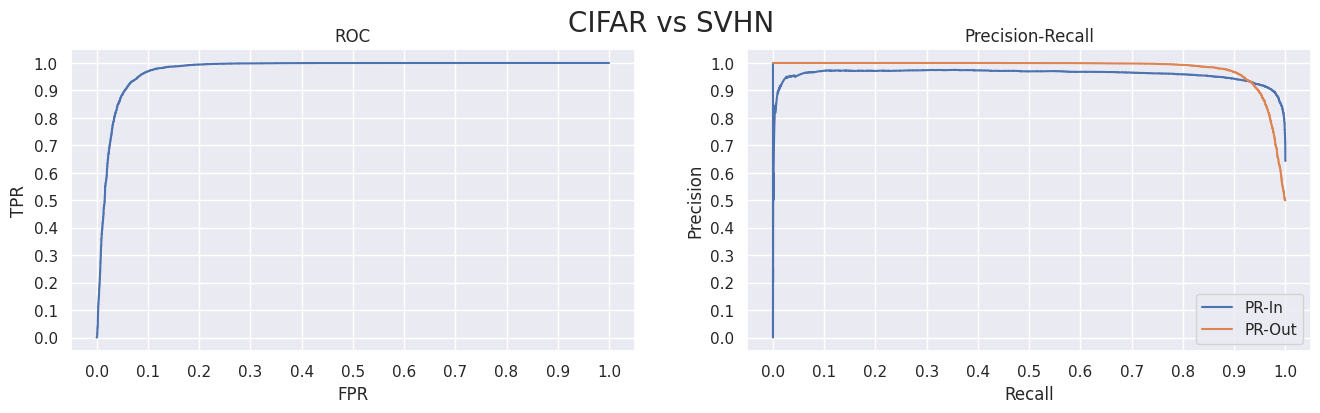

CIFAR vs SVHN
----------------
ROC-AUC: 97.5198
PR-AUC (In/Out): 95.8584 / 98.1395
FPR (95% TPR): 8.03%
Detection Error: 6.43%


{'fpr_tpr95': 0.0803,
 'de': 0.06430000000000001,
 'roc_auc': 0.9751981200000002,
 'pr_auc_in': 0.9585838468255954,
 'pr_auc_out': 0.9813946570850498,
 'fpr_tpr80': 0.0338,
 'ap': 0.9586519178567035}

In [29]:
ood_metrics(-results_101["GMM"]["test_scores"], -results_101["GMM"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

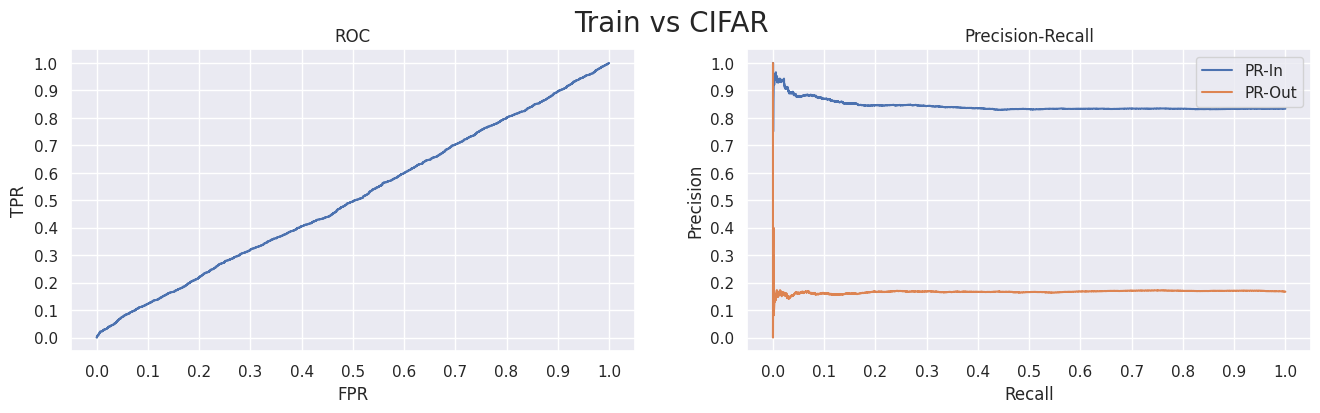

Train vs CIFAR
----------------
ROC-AUC: 50.5910
PR-AUC (In/Out): 84.3150 / 16.6548
FPR (95% TPR): 95.05%
Detection Error: 48.59%


{'fpr_tpr95': 0.9505,
 'de': 0.4859,
 'roc_auc': 0.5059103,
 'pr_auc_in': 0.8431495212659971,
 'pr_auc_out': 0.1665484256956298,
 'fpr_tpr80': 0.791,
 'ap': 0.8431888817553066}

In [30]:
ood_metrics(-results_101["GMM"]["train_scores"], -results_101["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [31]:
results_101["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,62.50,30.560000,73.612253,64.585948,77.932650,40.30,64.594516
SVHN,99.48,50.000000,15.569543,33.109541,33.158325,97.19,33.113064
LSUN_crop,97.77,49.995000,21.948491,34.723079,35.920198,93.32,34.726958
LSUN_resize,62.14,31.595000,70.700204,60.686126,76.750136,43.17,60.693835
Imagenet_crop,86.88,45.430000,48.762508,45.387751,55.549525,71.00,45.393524
Imagenet_resize,66.62,32.170000,71.690721,63.268864,75.956173,43.72,63.279611
iSUN,66.36,32.655420,70.747015,59.717971,77.139163,44.61,59.729763
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,92.62,43.728194,56.462675,84.239468,20.620351,70.90,84.241758


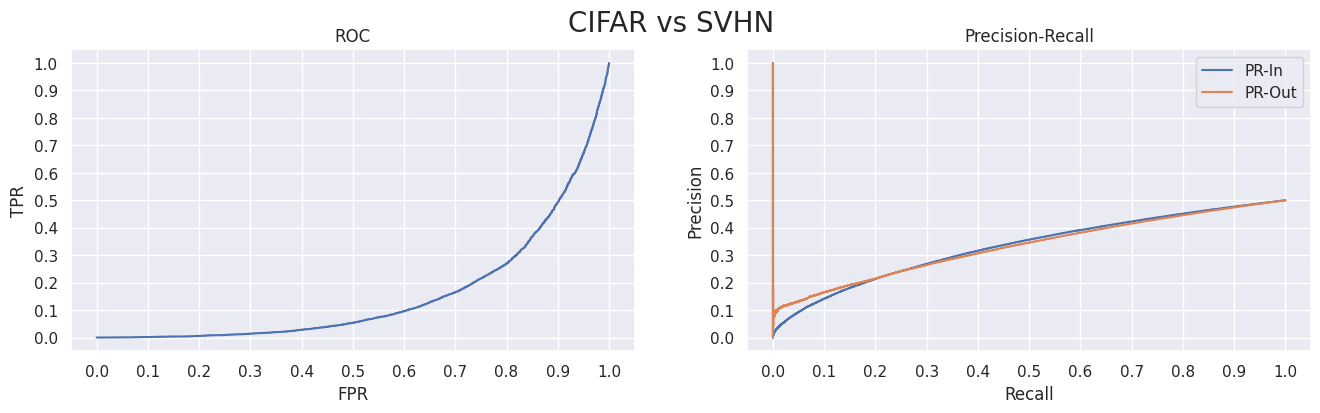

CIFAR vs SVHN
----------------
ROC-AUC: 15.5695
PR-AUC (In/Out): 33.1095 / 33.1583
FPR (95% TPR): 99.48%
Detection Error: 50.00%


{'fpr_tpr95': 0.9948,
 'de': 0.5,
 'roc_auc': 0.155695435,
 'pr_auc_in': 0.3310954062024867,
 'pr_auc_out': 0.33158324733402134,
 'fpr_tpr80': 0.9719,
 'ap': 0.3311306408180852}

In [32]:
ood_metrics(-results_101["Flow"]["test_scores"], -results_101["Flow"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

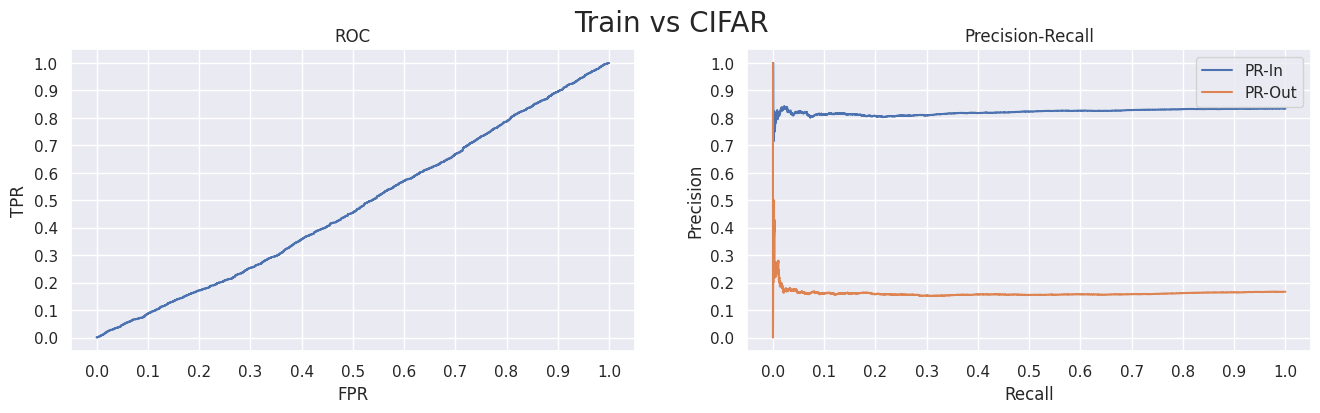

Train vs CIFAR
----------------
ROC-AUC: 47.4516
PR-AUC (In/Out): 82.1970 / 16.1046
FPR (95% TPR): 95.00%
Detection Error: 49.74%


{'fpr_tpr95': 0.95,
 'de': 0.49745,
 'roc_auc': 0.474516125,
 'pr_auc_in': 0.8219695630934882,
 'pr_auc_out': 0.1610459873367213,
 'fpr_tpr80': 0.803,
 'ap': 0.822027920129609}

In [33]:
ood_metrics(-results_101["Flow"]["train_scores"], -results_101["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [34]:
results_101["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
CelebA,77.77,38.260000,62.255788,54.793607,66.935183,55.90,54.802859
SVHN,3.00,3.950000,99.259233,99.216482,99.289315,0.59,99.216538
LSUN_crop,2.83,3.525000,99.276314,99.101767,99.406155,0.91,99.101847
LSUN_resize,5.53,5.195000,98.404026,97.640890,98.750367,1.98,97.643854
Imagenet_crop,4.97,4.770000,98.494348,97.736168,98.845094,1.93,97.737301
Imagenet_resize,3.36,3.645000,99.099587,98.771994,99.286850,1.12,98.772242
iSUN,4.72,4.587787,98.683861,97.871741,99.064132,1.70,97.873196
Gaussian,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
Uniform,0.00,0.000000,100.000000,100.000000,100.000000,0.00,100.000000
All Images,4.34,4.423012,98.793995,99.656373,97.057127,1.57,99.656383


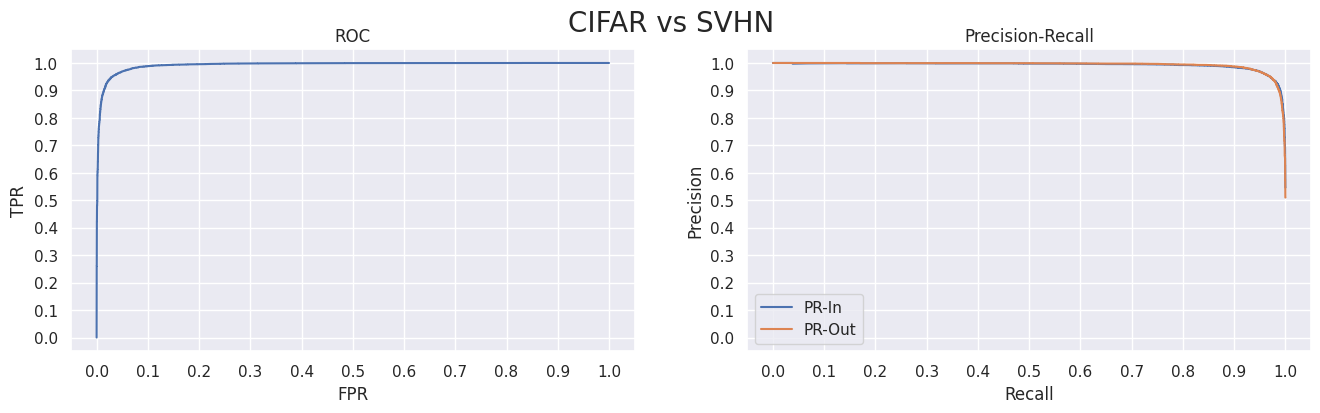

CIFAR vs SVHN
----------------
ROC-AUC: 99.2592
PR-AUC (In/Out): 99.2165 / 99.2893
FPR (95% TPR): 3.00%
Detection Error: 3.95%


{'fpr_tpr95': 0.03,
 'de': 0.03950000000000001,
 'roc_auc': 0.9925923299999998,
 'pr_auc_in': 0.9921648249429564,
 'pr_auc_out': 0.9928931529482525,
 'fpr_tpr80': 0.0059,
 'ap': 0.9921653779152138}

In [35]:
ood_metrics(results_101["KD"]["test_scores"], results_101["KD"]["ood_scores"][1], names=(LABELS[1], LABELS[3]), plot=True, verbose=True)

### Validation Check

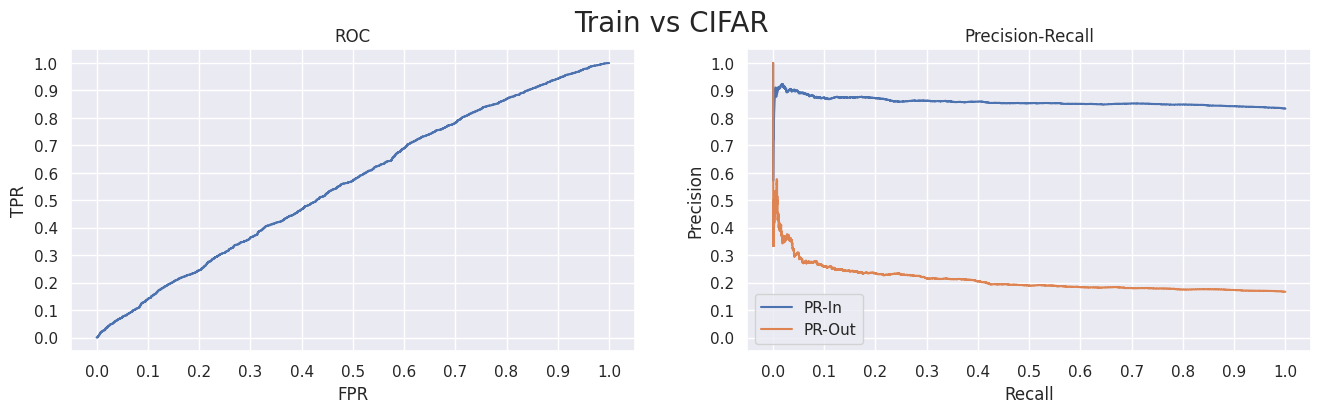

Train vs CIFAR
----------------
ROC-AUC: 55.9905
PR-AUC (In/Out): 85.7844 / 20.9991
FPR (95% TPR): 90.75%
Detection Error: 45.16%


{'fpr_tpr95': 0.9075,
 'de': 0.45165,
 'roc_auc': 0.55990545,
 'pr_auc_in': 0.8578436242191549,
 'pr_auc_out': 0.20999116827162218,
 'fpr_tpr80': 0.705,
 'ap': 0.8579000012905953}

In [36]:
ood_metrics(results_101["KD"]["train_scores"], results_101["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)